In [1]:
import scipy
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import csv
import numpy as np
import collections
import seaborn as sns

sns.set()

In [2]:
data = []
with open('ml-100k/u.data') as csvfile:
    spamreader = csv.reader(csvfile, delimiter='\t')
    for row in spamreader:
        data.append([int(row[0]) - 1, int(row[1]) - 1, int(row[2])])
data = np.array(data)

num_observations = len(data)  # num_observations = 100,000
num_users = max(data[:, 0]) + 1  # num_users = 943, indexed 0,...,942
num_items = max(data[:, 1]) + 1  # num_items = 1682 indexed 0,...,1681

np.random.seed(1)
num_train = int(0.8 * num_observations)
perm = np.random.permutation(data.shape[0])
train = data[perm[0:num_train], :]
test = data[perm[num_train::], :]

In [3]:
def error(r_hat, r):
    return np.mean((r_hat[r[:, 0], r[:, 1]] - r[:, 2]) ** 2)

In [4]:
movies_scores = collections.defaultdict(list)
mu = np.array([0.0 for _ in range(num_items)])

for u, m, score in train:
    movies_scores[m].append(score)

for m, scores in movies_scores.items():
    mu[m] = np.mean(scores)

r_hat_mu = np.zeros((num_users, num_items))
r_hat_mu[train[:, 0], train[:, 1]] = train[:, 2]

for m, score in enumerate(mu):
    for j in range(num_users):
        if r_hat_mu[j, m] == 0:
            r_hat_mu[j, m] = mu[m]

err = error(r_hat_mu, test)

print(err)

1.0635642005674517


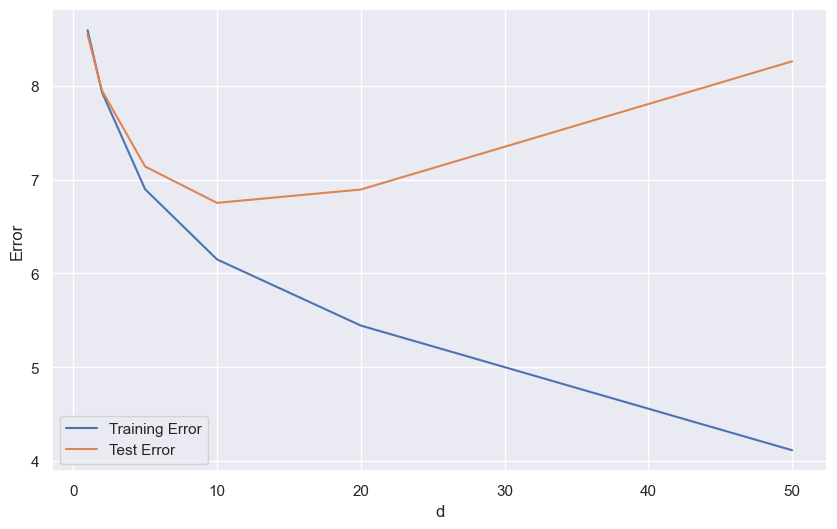

In [5]:
# B.1.b
ds = [1, 2, 5, 10, 20, 50]

r_hat = np.zeros((num_users, num_items))
r_hat[train[:, 0], train[:, 1]] = train[:, 2]

train_errors = []
test_errors = []

for d in ds:
    U, S, V = scipy.sparse.linalg.svds(r_hat, d)
    r_hat_rank_d = np.matmul(np.matmul(U, np.diag(S)), V)

    train_errors.append(error(r_hat_rank_d, train))
    test_errors.append(error(r_hat_rank_d, test))

plt.figure(figsize=(10, 6))
plt.plot(ds, train_errors, label='Training Error')
plt.plot(ds, test_errors, label='Test Error')
plt.legend()
plt.xlabel('d')
plt.ylabel('Error')
plt.savefig('B1b.png')
plt.show()

d=1 sigma=1.5 lambda=0.01 train=0.8328283569238345 test=0.9100048159972677
d=2 sigma=1.5 lambda=0.01 train=0.7360134176518516 test=0.9144070529312442
d=5 sigma=1.5 lambda=0.01 train=0.5927713319267643 test=1.192529573470062
d=10 sigma=1.5 lambda=0.01 train=0.4355648492903801 test=2.1952986082111225
d=20 sigma=1.5 lambda=0.01 train=0.244039472702481 test=3.339958700037884
d=50 sigma=1.5 lambda=0.01 train=0.029872810479253404 test=4.040912051666085


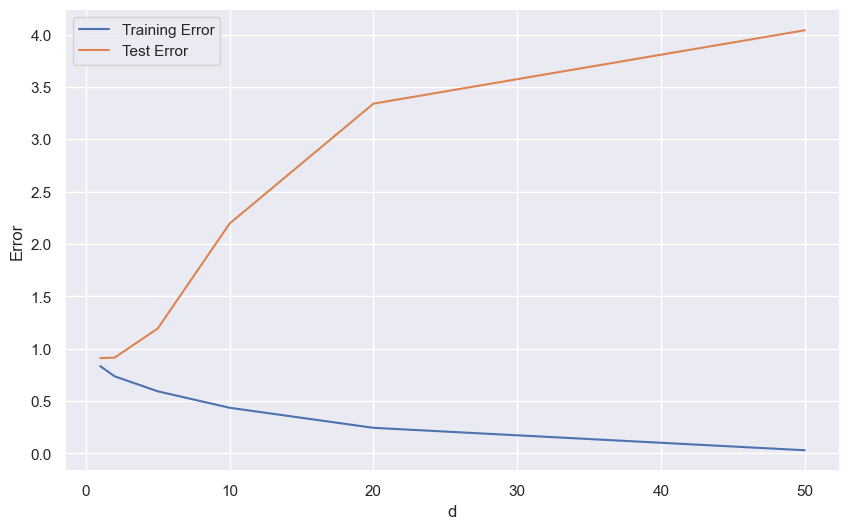

In [8]:
# B.1.c.new
# Alernating Minimization refrerence from https://math.stackexchange.com/questions/1072451/analytic-solution-for-matrix-factorization-using-alternating-least-squares
def alternating_minimization_U(d, r_hat, fixed_vector, lambda_reg=0.01):
    A = fixed_vector.T.dot(fixed_vector) + np.eye(d) * lambda_reg
    return r_hat.dot(fixed_vector).dot(np.linalg.inv(A))

def alternating_minimization_V(d, r_hat, fixed_vector, lambda_reg=0.01):
    A = fixed_vector.T.dot(fixed_vector) + np.eye(d) * lambda_reg
    return np.linalg.inv(A).dot(fixed_vector.T.dot(r_hat))

iters = 20
ds = [1, 2, 5, 10, 20, 50]
sigmas = [1.5]
lambda_regs = [0.01]
train_errors = []
test_errors = []
r_hat = np.zeros((num_users, num_items))
r_hat[train[:, 0], train[:, 1]] = train[:, 2]


for d in ds:
    for sigma in sigmas:
        for lambda_reg in lambda_regs:
            U = sigma * np.random.random((num_users, d))
            V = sigma * np.random.random((num_items, d))

            for _ in range(iters):
                U_ = np.zeros((num_users, d))
                V_ = np.zeros((num_items, d))

                for i in range(num_users):
                    U_[i] = alternating_minimization_U(
                        d,
                        train[train[:, 0] == i, 2],
                        V[train[train[:, 0] == i, 1]]
                    )

                for j in range(num_items):
                    V_[j] = alternating_minimization_V(
                        d,
                        train[train[:, 1] == j, 2],
                        U_[train[train[:, 1] == j, 0]]
                    )

                r_hat_pred = U_.dot(V_.T)
                train_error = error(r_hat_pred, train)
                test_error = error(r_hat_pred, test)
                # print('sigma={} lambda={} train={} test={}'.format(sigma, lambda_reg, train_error, test_error))

                U = U_
                V = V_

            print('d={} sigma={} lambda={} train={} test={}'.format(d, sigma, lambda_reg, train_error, test_error))

            train_errors.append(error(r_hat_pred, train))
            test_errors.append(error(r_hat_pred, test))

# print(train_errors, test_errors)

plt.figure(figsize=(10, 6))
plt.plot(ds, train_errors, label='Training Error')
plt.plot(ds, test_errors, label='Test Error')
plt.legend()
plt.xlabel('d')
plt.ylabel('Error')
plt.savefig('B1c.png')
plt.show()

sigma=1.5 lambda=0.01 train=1.8354387158950491 test=1.8835414761559042
sigma=1.5 lambda=0.01 train=1.1898657870140812 test=1.2474053237978875
sigma=1.5 lambda=0.01 train=1.0193361146578914 test=1.0789531719889394
d=1 sigma=1.5 lambda=0.01 train=0.9512649840584297 test=1.0129006381498917
sigma=1.5 lambda=0.01 train=1.3906653658097714 test=1.4279633334532151
sigma=1.5 lambda=0.01 train=1.0455121535466916 test=1.0998318969002172
sigma=1.5 lambda=0.01 train=0.947481234002538 test=1.0114117608707616
d=2 sigma=1.5 lambda=0.01 train=0.9067410738062627 test=0.9735589358341861
sigma=1.5 lambda=0.01 train=1.1003569627594212 test=1.157159931905924
sigma=1.5 lambda=0.01 train=0.9581096179403031 test=1.0257671628784433
sigma=1.5 lambda=0.01 train=0.9052505913978172 test=0.9836297989659093
d=5 sigma=1.5 lambda=0.01 train=0.8790604804313839 test=0.9627591097369245
sigma=1.5 lambda=0.01 train=1.2845511992846437 test=1.400838170964811
sigma=1.5 lambda=0.01 train=1.0672432644702905 test=1.18921433414751

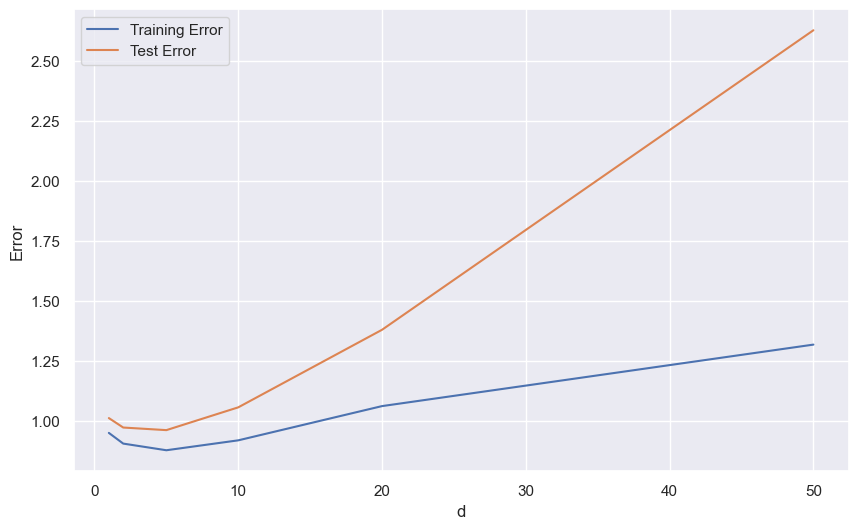

In [10]:
# B.1.d.new

iters = 320
ds = [1, 2, 5, 10, 20, 50]
sigmas = [1.5]
lambda_regs = [0.01]
train_errors = []
test_errors = []
r_hat = np.zeros((num_users, num_items))
r_hat[train[:, 0], train[:, 1]] = train[:, 2]

batch_size = 1000
learning_rate = 5e-3

for d in ds:
    for sigma in sigmas:
        for lambda_reg in lambda_regs:
            U = sigma * np.random.random((num_users, d))
            V = sigma * np.random.random((num_items, d))
            cnt = 0

            for _ in range(iters+1):
                U_ = np.zeros((num_users, d))
                V_ = np.zeros((num_items, d))

                # epoch
                if cnt > len(train):
                    cnt = 0
                    np.random.shuffle(train)
                    r_hat_pred = U.dot(V.T)
                    train_error = error(r_hat_pred, train)
                    test_error = error(r_hat_pred, test)
                    print('sigma={} lambda={} train={} test={}'.format(sigma, lambda_reg, train_error, test_error))
                # batch
                train_batch = train[cnt:cnt + batch_size]
                cnt += batch_size

                for i in range(num_users):
                    if np.sum(train_batch[train_batch[:, 0] == i, 2]) != 0:
                        fixed_vector = V[train_batch[train_batch[:, 0] == i, 1]]
                        U_[i] = U[i].dot(fixed_vector.T.dot(fixed_vector) + np.eye(d) * lambda_reg) - train_batch[train_batch[:, 0] == i, 2].dot(fixed_vector)

                for j in range(num_items):
                    if np.sum(train_batch[train_batch[:, 1] == j, 2]) != 0:
                        fixed_vector = U[train_batch[train_batch[:, 1] == j, 0]]
                        V_[j] = V[j].dot(fixed_vector.T.dot(fixed_vector) + np.eye(d) * lambda_reg) - train_batch[train_batch[:, 1] == j, 2].dot(fixed_vector)

                U -= learning_rate * U_
                V -= learning_rate * V_
                # print('sigma={} lambda={} train={} test={}'.format(sigma, lambda_reg, train_error, test_error))
    
            r_hat_pred = U.dot(V.T)
            train_error = error(r_hat_pred, train)
            test_error = error(r_hat_pred, test)
                
            print('d={} sigma={} lambda={} train={} test={}'.format(d, sigma, lambda_reg, train_error, test_error))

            train_errors.append(error(r_hat_pred, train))
            test_errors.append(error(r_hat_pred, test))


plt.figure(figsize=(10, 6))
plt.plot(ds, train_errors, label='Training Error')
plt.plot(ds, test_errors, label='Test Error')
plt.legend()
plt.xlabel('d')
plt.ylabel('Error')
plt.savefig('B1d.png')
plt.show()